In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import tifffile as tiff
import cv2
import torch.nn as nn
import albumentations as A
import numpy as np
import os
import time
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

### Setting up 
- define paths
- importing data
- visualising an image:label pair of a dummy index

In [222]:
image_files[0:5]

['kaggle\\input\\blood-vessel-segmentation\\train\\kidney_1_dense\\images\\0000.tif',
 'kaggle\\input\\blood-vessel-segmentation\\train\\kidney_1_dense\\images\\0001.tif',
 'kaggle\\input\\blood-vessel-segmentation\\train\\kidney_1_dense\\images\\0002.tif',
 'kaggle\\input\\blood-vessel-segmentation\\train\\kidney_1_dense\\images\\0003.tif',
 'kaggle\\input\\blood-vessel-segmentation\\train\\kidney_1_dense\\images\\0004.tif']

In [3]:
base_path = 'kaggle\\input\\blood-vessel-segmentation\\train'  

dataset = ['kidney_1_dense', 'kidney_1_voi', 'kidney_2', 'kidney_3_sparse'][0]

images_path = os.path.join(base_path, dataset, 'images')
labels_path = os.path.join(base_path, dataset, 'labels')

image_files = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.tif')])
label_files = sorted([os.path.join(labels_path, f) for f in os.listdir(labels_path) if f.endswith('.tif')])

def show_images(idx,titles= None, cmap='gray'):
    n = len(idx)*2
    fig = make_subplots(1, n)
    fig['layout'].update(margin=dict(l=0,r=0,b=0,t=0))
    for i, img in enumerate(idx*2):
        if i%2 == 0:
            image = tiff.imread(image_files[img])
        else:
            image = tiff.imread(label_files[img])
        figg = px.imshow(image, binary_string=True, width = 400)
        fig.add_trace(figg.data[0], row =  i//2 +1, col = i%2 +1)
    
    fig.update_layout(height = 500, width =1000)
    fig.show()



# idx = 250
# show_images([idx-25], titles=['First Image', 'First Label'])
# show_images([idx], titles=['First Image', 'First Label'])
# show_images([idx+25], titles=['First Image', 'First Label'])

### Resizing (downsampling) to make visualising not kill my PC & Normalizing to (0,1)
- shrinks image by a factor of 5
- takes one slice every 25 vertical steps 
- shrinks image from super big numbers to 0,1
- shrinks labels from 0/255 to 0/1

In [195]:
images = tiff.imread(image_files) # (2279, 1303, 912)
labels = tiff.imread(label_files)

In [217]:
np.array(
    [cv2.resize(tiff.imread(image_files[m]), (0, 0), fx=(1/shrink_factor), fy=(1/shrink_factor), interpolation=cv2.INTER_CUBIC) 
     for m in range(len(image_files)) ]).shape

(2279, 130, 91)

In [218]:
np.array(
    [cv2.resize(images[m], (0, 0), fx=(1/shrink_factor), fy=(1/shrink_factor), interpolation=cv2.INTER_CUBIC) 
     for m in range(len(image_files)) ])

(2279, 130, 91)

In [209]:
def resize_2D(images, shrink_factor = 5, steps = 50, axis_swap = None ): 
    '''
    image_files: array of images (Z (depth), width, height)
    shrink_factor: how much smaller 
    steps: how many Z data are we skipping at a time
    
    ** note: resizing has to be done in a LOOP
    '''
    return np.array([ cv2.resize(images[m], (0, 0), fx=(1/shrink_factor), fy=(1/shrink_factor), interpolation=cv2.INTER_CUBIC) 
                     for m in range(len(image_files)) ])

def normalize_2D(images):
    im_min, im_max = np.min(images, axis=(1, 2)), np.max(images, axis=(1, 2))
    im_min, im_max = im_min[:,np.newaxis, np.newaxis] , im_max[:,np.newaxis, np.newaxis] 
    
    return (images - im_min) / (im_max - im_min) 

In [219]:
resized_images = resize_2D(images)
resized_labels = resize_2D(labels)

normalized_image = normalize_2D(resized_images)
normalized_label = np.divide(resized_labels, 255)

image_label_sum = np.stack([normalized_image,normalized_label, normalize_2D(normalized_image/1.25+normalized_label)], axis=0)

px.imshow(image_label_sum, facet_col = 0, facet_col_wrap = 3, animation_frame = 1,  binary_string = True, height = 600)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Visualising Augmentations

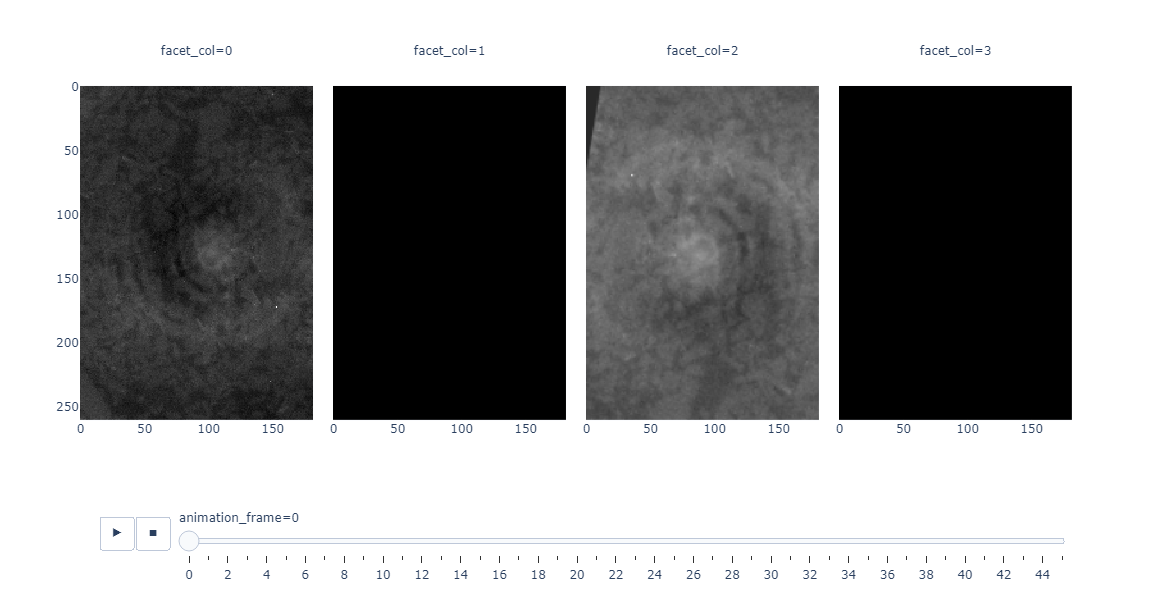

In [212]:
def augment_image(image, mask):
    h, w = image.shape
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0., rotate_limit=10, shift_limit=0., p=1, border_mode=0),
        A.RandomCrop(height = int(h*.8), width = int(w *.8), always_apply=True),
        A.RandomBrightnessContrast(p=1),

        A.Blur(blur_limit=1, p=.5),
        A.Resize(*image.shape)
    
    ])
    augmented = transform(image=image, mask=mask)
    augmented_image, augmented_mask = augmented['image'], augmented['mask']

    return augmented_image, augmented_mask

augs = np.array([augment_image(normalized_image[n].astype('float32'), normalized_label[n].astype('float32')) for n in range(normalized_image.shape[0])])
augs = augs.swapaxes(0,1)

image_label_pair = np.stack([normalized_image,normalized_label], axis=0)

img_aug_pair = np.concatenate([image_label_pair,augs ], axis = 0)

px.imshow(img_aug_pair, facet_col = 0, animation_frame = 1, binary_string = True,  height = 600)

## Axes swapping?

In [ ]:
np.swapaxes(images,0,1)

In [174]:
augs.shape

(2, 46, 50, 50)

### Volume Plots

In [11]:
from skimage import io

H ,r, c = normalized_image.shape # row and column 

fig =  make_subplots(rows=1, cols=2,  specs=[[{"type": "surface"}, {"type": "surface"}]])

## Define Frames to inject into graph object
frames = [
            go.Frame(data=[go.Surface(z = (H/10 - 0.1*h) * np.ones((r, c)), surfacecolor=normalized_image[h]),
                          go.Surface(z = (H/10 - 0.1*h) * np.ones((r, c)), surfacecolor=normalized_label[h])], name=str(h) ) 
            for h in range(H)
         ]

def frame_args(duration):
    return {
            "frame": {"duration": duration},
            "mode": "immediate",
            "fromcurrent": True,
            "transition": {"duration": duration, "easing": "linear"},
        }

## Define how its animated
sliders = [
            {
                "pad": {"b": 0, "t": 0},
                "steps": [
                    {
                        "args": [[f.name], frame_args(0)],
                        "label": str(k),
                        "method": "animate",
                    }
                    for k, f in enumerate(fig.frames)
                ],
            }
        ]

## Initialising 3D images as go.Surfaces, else it wouldn't generate a 3D blank plot

fig.add_trace(go.Surface(
    z = H/10* np.ones((r, c)),
    surfacecolor=np.flipud(normalized_image[0]),
    colorscale='Gray',
    colorbar=dict(thickness=20, ticklen=2)
    ),1,1)

fig.add_trace(go.Surface(
    z = H/10* np.ones((r, c)),
    surfacecolor=np.flipud(normalized_label[0]),
    colorscale='Gray',
    colorbar=dict(thickness=20, ticklen=2)
    ),1,2)

# Inject frames and update slider 

fig.update(frames=frames)
fig.update_layout(
         title='Slices in volumetric data',
         height=600,
         sliders=sliders
)
fig.update_scenes(zaxis=dict(range=[-0.1, H/10], autorange=False),aspectratio=dict(x=1, y=1, z=1))

# suppressing the default output option..
1

1

In [ ]:
# 3D volume for just image
fig = go.Figure(
                frames = [
                            go.Frame(data=go.Surface(z = (H/10 - 0.1*h) * np.ones((r, c)), surfacecolor=normalized_image[h],), name=str(h) ) 
                            for h in range(H)
                         ]
                )

# inject the frames as slices in a loop, one Z-slice is an iamge 

# note: the frame property is for animation (what images to loop through), can't seem to set an "initial frame state" so we manually inject one frame as the starting data

fig.add_trace(go.Surface(
    z = H/10* np.ones((r, c)),
    surfacecolor=np.flipud(normalized_image[0]),
    colorscale='Gray',
    colorbar=dict(thickness=20, ticklen=2)
    ))

fig.update_layout(
         title='Slices in volumetric data',
         width=1200,
         scene=dict(
                    zaxis=dict(range=[-0.1, H/10], autorange=False),
                    aspectratio=dict(x=1, y=1, z=1),
                    ),
         sliders=sliders
)

fig.show()